<a href="https://colab.research.google.com/github/jfogarty/machine-learning-intro-workshop/blob/master/notebooks/data-explore-darwin-finches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Darwin's finches

From [data-science-nano-projects](https://github.com/hugorcf/data-science-nano-projects) by [Hugo Ferreira](https://github.com/hugorcf) (2018)

Updated by [John Fogarty](https://github.com/jfogarty) for Python 3.6 and [Base2 MLI](https://github.com/base2solutions/mli).

In this notebook, I will perform some very basic data and statistical analysis on data on [Darwin's finches](https://en.wikipedia.org/wiki/Darwin%27s_finches).

<img src="https://github.com/jfogarty/machine-learning-intro-workshop/blob/master/images/Darwins_finches.jpg?raw=1" alt="Darwins_finches" style="width: 600px;"/>

This analysis was done as practice in Python and basic stats concepts such as hypothesis testing, confidnece intervals and linear regression.

The original data can be found in:

> Grant PR, Grant BR (2014) Data from: 40 years of evolution. Darwin's finches on Daphne Major Island. Dryad Digital Repository. https://doi.org/10.5061/dryad.g6g3h

The inspiration to create this notebook came from the *Statistical Thinking in Python* courses in [DataCamp](https://www.datacamp.com). The datasets (in csv format) were obtained in [here](https://github.com/johnashu/datacamp/tree/master/statistical-thinking-in-python-part-2).

In [62]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Seaborn and matplotlib styles
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')

## Finch beak length and depth

We'll focus our attention to two species of finches, the [medium ground finch](https://en.wikipedia.org/wiki/Medium_ground_finch) (*Geospiza fortis*) and the [common cactus finch](https://en.wikipedia.org/wiki/Common_cactus_finch) (*Geospiza scandens*), which live in the island of Daphne Major.

<img src="https://github.com/jfogarty/machine-learning-intro-workshop/blob/master/images/Geospiza_fortis.jpg?raw=1" alt="Geospiza_fortis" style="width: 400px;"/>

<img src="https://github.com/jfogarty/machine-learning-intro-workshop/blob/master/images/Geospiza_scandens.jpg?raw=1" alt="Geospiza_scandens" style="width: 400px;"/>

We have data for the beak length and depth for both species in 1975 and 2012.

### Exploratory data analysis (EDA) of beak length and depth


First, we import the data relative to 1975 and 2012 contained in two csv files.

In [63]:
import os
RAWURL = 'https://raw.githubusercontent.com/jfogarty/machine-learning-intro-workshop/master/data/'
TMPDIR = './tmpData'
if not os.path.exists(TMPDIR) : os.makedirs(TMPDIR)
files = ['finch_beaks_1975.csv', 'finch_beaks_2012.csv', 'fortis_beak_depth_heredity.csv', 'scandens_beak_depth_heredity.csv']
for f in files:
    FROMURL = os.path.join(RAWURL, f)
    TOPATH = os.path.join(TMPDIR, f)
    !curl $FROMURL -o $TOPATH

In [64]:
data_1975 = pd.read_csv(os.path.join(TMPDIR, 'finch_beaks_1975.csv'))
data_2012 = pd.read_csv(os.path.join(TMPDIR, 'finch_beaks_2012.csv'))

In [65]:
data_1975.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 4 columns):
band               403 non-null int64
species            403 non-null object
Beak length, mm    403 non-null float64
Beak depth, mm     403 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 12.7+ KB


In [66]:
data_1975.head()

,band,species,"Beak length, mm","Beak depth, mm"
0,2,fortis,9.4,8.0
1,9,fortis,9.2,8.3
2,12,fortis,9.5,7.5
3,15,fortis,9.5,8.0
4,305,fortis,11.5,9.9


In [67]:
data_2012.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 4 columns):
band       248 non-null int64
species    248 non-null object
blength    248 non-null float64
bdepth     248 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 7.9+ KB


In [68]:
data_2012.head()

,band,species,blength,bdepth
0,19022,fortis,10.0,8.5
1,19028,fortis,12.5,8.9
2,19032,fortis,9.3,7.5
3,19041,fortis,10.3,9.6
4,19044,fortis,11.0,9.2


In [69]:
# make column titles equal in both dataframes
data_1975.columns = data_2012.columns

In [70]:
data_1975.head()

,band,species,blength,bdepth
0,2,fortis,9.4,8.0
1,9,fortis,9.2,8.3
2,12,fortis,9.5,7.5
3,15,fortis,9.5,8.0
4,305,fortis,11.5,9.9


It will be useful for the analysis to have a single dataframe with all the information.

In [71]:
data = pd.concat([data_1975, data_2012], keys=['1975', '2012'], names=['year', ])

In [72]:
data.head()

band species  blength  bdepth
year                                 
1975 0     2  fortis      9.4     8.0
     1     9  fortis      9.2     8.3
     2    12  fortis      9.5     7.5
     3    15  fortis      9.5     8.0
     4   305  fortis     11.5     9.9

We obtain a dataframe with a hierarchical index, with levels 'year' and 'index'.It is convenient to have a simple index, which can be otained by resetting the index and dropping the 'index' column.

In [73]:
data.reset_index(level='year', inplace=True)

In [74]:
data.head()

,year,band,species,blength,bdepth
0,1975,2,fortis,9.4,8.0
1,1975,9,fortis,9.2,8.3
2,1975,12,fortis,9.5,7.5
3,1975,15,fortis,9.5,8.0
4,1975,305,fortis,11.5,9.9


First, we plot the beak length and depth measurements in 1975 and 2012 in two bee swarm plots.

#### Beak length

Text(0, 0.5, 'beak length (mm)')

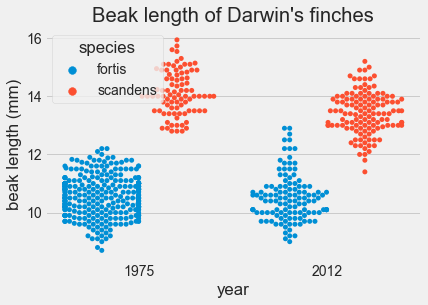

In [75]:
sns.swarmplot(x='year', y='blength', data=data, hue='species', dodge=True)
plt.title("Beak length of Darwin's finches")
plt.xlabel('year')
plt.ylabel('beak length (mm)')

We see that the *Geospiza scandens* has, on average, a longer beak that the *Geospiza fortis*, in both years, even though the difference seems smaller in 2012 than in 1975. In particular, the beak length of *Geospiza scandens* seems to have slightly decreased from 1975 to 2012.

#### Beak depth

Text(0, 0.5, 'beak depth (mm)')

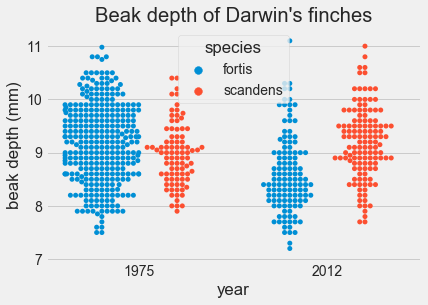

In [76]:
sns.swarmplot(x='year', y='bdepth', data=data, hue='species', dodge=True)
plt.title("Beak depth of Darwin's finches")
plt.xlabel('year')
plt.ylabel('beak depth (mm)')

As for the beak depth, the difference between the species is much smaller than in the case of the beak length. It is hard to see if there is a clear difference in the datasets bewtween the two years. To help with this, we will build the **empirical cumulative distribution function** (ECDF) for each data (for more info, see [here](https://en.wikipedia.org/wiki/Empirical_distribution_function)).

In [77]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

**_Geospiza fortis_**

In [78]:
# arrays with beak depth for each year for fortis species
bd_1975_fortis = data[(data['year'] == '1975') & (data['species'] == 'fortis')]['bdepth'].values
bd_2012_fortis = data[(data['year'] == '2012') & (data['species'] == 'fortis')]['bdepth'].values

In [79]:
# computation of ECDF for fortis species
x_bd_1975_fortis, y_bd_1975_fortis = ecdf(bd_1975_fortis)
x_bd_2012_fortis, y_bd_2012_fortis = ecdf(bd_2012_fortis)

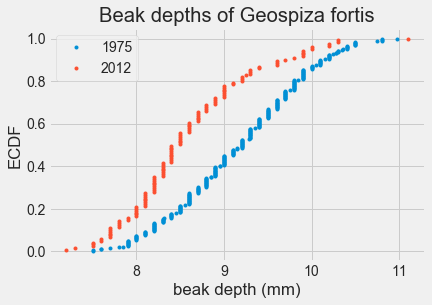

In [80]:
# plot of ECDFs for fortis species
plt.plot(x_bd_1975_fortis, y_bd_1975_fortis, marker='.', ls='none')
plt.plot(x_bd_2012_fortis, y_bd_2012_fortis, marker='.', ls='none')
plt.title('Beak depths of Geospiza fortis')
plt.xlabel('beak depth (mm)')
plt.ylabel('ECDF')
plt.legend(('1975', '2012'), loc='upper left')

The differences in beak depths between 1975 and 2012 are much clearer in the ECDF. Namely, the mean is mean is *smaller* in the 2012 data. 

**_Geospiza scandens_**

In [81]:
# arrays with beak depth for each year for scandens species
bd_1975_scandens = data[(data['year'] == '1975') & (data['species'] == 'scandens')]['bdepth'].values
bd_2012_scandens = data[(data['year'] == '2012') & (data['species'] == 'scandens')]['bdepth'].values

In [82]:
# computation of ECDF for scandens species
x_bd_1975_scandens, y_bd_1975_scandens = ecdf(bd_1975_scandens)
x_bd_2012_scandens, y_bd_2012_scandens = ecdf(bd_2012_scandens)

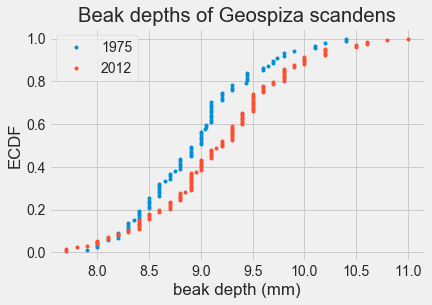

In [83]:
# plot of ECDFs for scandens species
plt.plot(x_bd_1975_scandens, y_bd_1975_scandens, marker='.', ls='none')
plt.plot(x_bd_2012_scandens, y_bd_2012_scandens, marker='.', ls='none')
plt.title('Beak depths of Geospiza scandens')
plt.xlabel('beak depth (mm)')
plt.ylabel('ECDF')
plt.legend(('1975', '2012'), loc='upper left')

Once again, the difference between the 1975 and 2012 is clearer, and the mean of the beak depth is *larger* in the 2012 data.

### Parameter estimation of beak depths

Let's now focus on the beak depth measurements of the *Geospiza scandens*. The EDA above indicates that the mean of the beak depth is larger in the 2012 data, in comparison with the 1975 data. We now estimate the difference of the mean beak depth and report a 95% confidence interval. For that, we will generate **bootstrap replicates** from the dataset.

In [84]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        # bootstrap resampling using np.random.choice
        bs_replicates[i] = func(np.random.choice(data, size=len(data)))

    return bs_replicates

First, we compute the *observed* difference of means of the beak depth in 2012 and 1975:

In [85]:
np.mean(bd_2012_scandens) - np.mean(bd_1975_scandens)

0.22622047244094645

Second, we obtain 10000 bootstrap replicates of the mean for the 1975 and 2012 beak depths and their difference:

In [86]:
bs_replicates_1975 = draw_bs_reps(bd_1975_scandens, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_scandens, np.mean, size=10000)
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

Using the replicates, we compute the **95% confidence interval** for the difference of means:

In [87]:
np.percentile(bs_diff_replicates, [2.5, 97.5])

array([0.05998423, 0.38934227])

It is quite clear from the observed difference of means and its 95% confidence interval that the beaks of the *Geospiza scandens* got deeper from 1975 to 2012.

### Hypothesis test: are the beak depths larger in 2012?

As mentioned above, it is clear that the mean of the beak depth of the *Geospiza scandens* has increased from 1975 to 2012. Is it possible that this effect is due to random chance? That is, what is the probability that we would obtain the observed difference in means if the means were actually the same?

To check this, we perform a [**hypothesis test**](http://mathworld.wolfram.com/HypothesisTesting.html).

**Null hypothesis:** the mean beak depth in 1975 is equal to the mean beak depth in 2012.

The **test statistic** we are going to use is the difference in mean beak depth. Under the null hypothesis, it should be zero. To test the null hypothesis, we are going to shift the two data sets so that they have the same mean, and then resample them using bootstrap and compute the difference of means. Finally, we compute the [**p-value**](https://en.wikipedia.org/wiki/P-value), that is the probability of obtaining a difference in mean beak depth equal or greater than the *observed* difference in mean beak depth, under the assumption the null hypothesis is true.

In [88]:
# mean of the combined data set
combined_mean = np.mean(np.concatenate((bd_1975_scandens, bd_2012_scandens)))

# shift of the data sets so that they have the same mean (combined_mean)
bd_1975_scandens_shifted = bd_1975_scandens - np.mean(bd_1975_scandens) + combined_mean
bd_2012_scandens_shifted = bd_2012_scandens - np.mean(bd_2012_scandens) + combined_mean

# obtain 10000 bootstrap replicates of the mean for the shifted data sets and their difference
bs_replicates_1975 = draw_bs_reps(bd_1975_scandens_shifted, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_scandens_shifted, np.mean, size=10000)
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# compute the p-value
p = np.sum(bs_diff_replicates >= np.mean(bd_2012_scandens) - np.mean(bd_1975_scandens)) / len(bs_diff_replicates)

The **[p-value](https://en.wikipedia.org/wiki/P-value)** is then:

In [89]:
print(p)

0.005


Therefore, 0.34% of the bootstrap replicates had a difference in mean beak depth equal or greater than the observed in the samples. This indicates that the probability that the increase in beak depth is due to chance is only 0.34%, thus, there is a *statistically significant* difference. For the samples, that difference was approximately 0.2 mm in 37 years, which is significant by evolutionary standards. If, for example, the beak depth kept changing at this rate, it would double in only 400 years!

### Variation of beak shape

Above, we saw that the beak depth for the *Geospiza scandens* increased from 1975 and 2012. We may also wonder how the beak *shape* has evolved, that is, the ratio between the beak depth and length. If the length and the depth have increased approximately in the same proportion, the overall shape of the beak would not change appreciably.

Let's start with some basic EDA, by making a scatter plot of the beak depth versus beak length for the 1975 and 2012 data.

In [90]:
# arrays with beak length for each year for scandens species
bl_1975_scandens = data[(data['year'] == '1975') & (data['species'] == 'scandens')]['blength'].values
bl_2012_scandens = data[(data['year'] == '2012') & (data['species'] == 'scandens')]['blength'].values

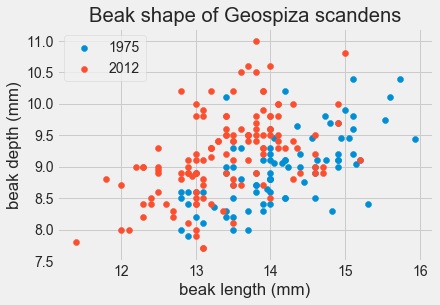

In [91]:
# scatter plot of beak depth vs length for the scandens species
plt.scatter(x=bl_1975_scandens, y=bd_1975_scandens)
plt.scatter(x=bl_2012_scandens, y=bd_2012_scandens)
plt.title('Beak shape of Geospiza scandens')
plt.xlabel('beak length (mm)')
plt.ylabel('beak depth (mm)')
plt.legend(('1975', '2012'), loc='upper left')

We see (as in the previous plots) that the beaks got deeper (the red points are slightly higher) but also shorter (the red points are mostly to the left). Thus, it seems that the beak shape has *not* stayed the same. However, in both years, it looks like the beak depth increases approximately linearly with its length.

To see that, let's perform a liner regression for both the 1975 and 2012 data.

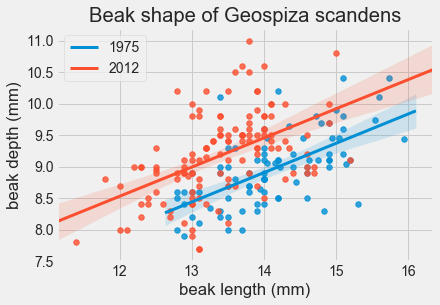

In [92]:
# scatter plot of beak depth vs length for the scandens species and linear regression for each year
sns.regplot(x=bl_1975_scandens, y=bd_1975_scandens, ci=95, scatter_kws={"s": 30}, line_kws={"lw": 3})
sns.regplot(x=bl_2012_scandens, y=bd_2012_scandens, ci=95, scatter_kws={"s": 30}, line_kws={"lw": 3})
plt.title('Beak shape of Geospiza scandens')
plt.xlabel('beak length (mm)')
plt.ylabel('beak depth (mm)')
plt.legend(('1975', '2012'), loc='upper left')

Below, we obtain the linear regression parameters and their 95% confidence intervals (95% CI), as represented in the plot above. For that, we first define a new function which performs pairs bootstrap for linear regression.

In [93]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_a_reps, bs_b_reps
    bs_a_reps = np.empty(size)
    bs_b_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        # bootstrap resampling using np.random.choice
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_a_reps[i], bs_b_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_a_reps, bs_b_reps

In [94]:
# Compute the linear regressions parameters
a_1975, b_1975 = np.polyfit(bl_1975_scandens, bd_1975_scandens, 1)
a_2012, b_2012 = np.polyfit(bl_2012_scandens, bd_2012_scandens, 1)

# Perform pairs bootstrap for the linear regressions
bs_a_reps_1975, bs_b_reps_1975 = draw_bs_pairs_linreg(bl_1975_scandens, bd_1975_scandens, size=1000)
bs_a_reps_2012, bs_b_reps_2012 = draw_bs_pairs_linreg(bl_2012_scandens, bd_2012_scandens, size=1000)

# Compute confidence intervals of slopes
a_conf_int_1975 = np.percentile(bs_a_reps_1975, [2.5, 97.5])
a_conf_int_2012 = np.percentile(bs_a_reps_2012, [2.5, 97.5])
b_conf_int_1975 = np.percentile(bs_b_reps_1975, [2.5, 97.5])
b_conf_int_2012 = np.percentile(bs_b_reps_2012, [2.5, 97.5])

# Print the results
print("Linear regression for 1975: a =", round(a_1975, 3), ", 95% CI =", a_conf_int_1975.round(3),
      ", b =", round(b_1975, 3), ", 95% CI =", b_conf_int_1975.round(3))
print("Linear regression for 2012: a =", round(a_2012, 3), ", 95% CI =", a_conf_int_2012.round(3),
      ", b =", round(b_2012, 3), ", 95% CI =", b_conf_int_2012.round(3))

Linear regression for 1975: a = 0.465 , 95% CI = [0.335 0.587] , b = 2.391 , 95% CI = [0.669 4.247]
Linear regression for 2012: a = 0.463 , 95% CI = [0.328 0.597] , b = 2.977 , 95% CI = [1.186 4.752]


We see that both linear regressions have approximately the same slope (for every mm in beak length the depth increases about half mm), but different intercepts. But how did the ratio of beak length to depth evolved from 1975 to 2012?

Below we compute the mean ratio in both 1975 and 2012 and theirn 95% confidence interval.

In [95]:
# compute length-to-depth ratios
ratio_1975 = bl_1975_scandens / bd_1975_scandens
ratio_2012 = bl_2012_scandens / bd_2012_scandens

# compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, size=10000)

# compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5, 99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5, 99.5])

# print the results
print("Ratio in 1975: mean =", round(mean_ratio_1975, 3), ", 99% CI =", conf_int_1975.round(3))
print("Ratio in 2012: mean =", round(mean_ratio_2012, 3), ", 99% CI =", conf_int_2012.round(3))

Ratio in 1975: mean = 1.579 , 99% CI = [1.556 1.601]
Ratio in 2012: mean = 1.466 , 99% CI = [1.444 1.488]


We observe that the mean ratio decreased by about 0.1 mm (or 7%) and the 99% confidence intervals do not overlap. Therefore, we can conclude that the beak shape actually changed from 1975 to 2012.

## Heritability of beak depth

Another piece of data we have at our disposal is the beak depth of two parents and their respective offspring for both the *Geospiza fortis* and *Geospiza scandens*. We will analyse the heritability of the beak depth for both species.

### EDA of heritability

First, we import the data from two csv files, one for each species. For the *Geospiza fortis*, the csv file includes the beak depth for the offspring in one column, and then the beak depth for the respective male and female parent. For the *Geospiza scandens*, besides the offspring beak depths, the second csv file include the average beak depth for the parents.

In [96]:
heredity_fortis = pd.read_csv(os.path.join(TMPDIR, 'fortis_beak_depth_heredity.csv'))
heredity_scandens = pd.read_csv(os.path.join(TMPDIR, 'scandens_beak_depth_heredity.csv'))

In [97]:
heredity_fortis.columns = ['offspring', 'male', 'female']
heredity_fortis.head()

,offspring,male,female
0,10.70,10.90,9.3
1,9.78,10.70,8.4
2,9.48,10.70,8.1
3,9.60,10.70,9.8
4,10.27,9.85,10.4


In [98]:
heredity_scandens.columns = ['parents', 'offspring']
heredity_scandens.head()

,parents,offspring
0,8.3318,8.4190
1,8.4035,9.2468
2,8.5317,8.1532
3,8.7202,8.0089
4,8.7089,8.2215


In the case of the *fortis* data set, we add a column with the average beak depth for the parents.

In [99]:
heredity_fortis['parents'] = heredity_fortis[['male', 'female']].mean(axis=1)

In [100]:
heredity_fortis.head()

,offspring,male,female,parents
0,10.70,10.90,9.3,10.100
1,9.78,10.70,8.4,9.550
2,9.48,10.70,8.1,9.400
3,9.60,10.70,9.8,10.250
4,10.27,9.85,10.4,10.125


Let's make a scatter plot of the offspring beak depth versus the average parental beak depth for both species.

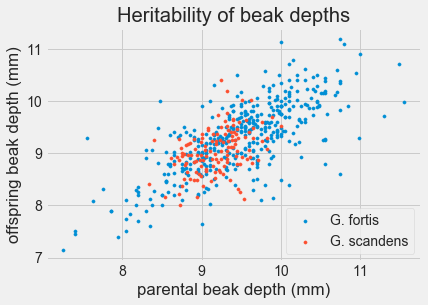

In [101]:
# plot of offspring beak depth vs parental beak depth
plt.scatter(heredity_fortis['parents'], heredity_fortis['offspring'], s=10)
plt.scatter(heredity_scandens['parents'], heredity_scandens['offspring'], s=10)
plt.title('Heritability of beak depths')
plt.xlabel('parental beak depth (mm)')
plt.ylabel('offspring beak depth (mm)')
plt.legend(('G. fortis', 'G. scandens'), loc='lower right')

It seems that there is a stronger correlation between the offspring and parental beak depth for the *Geospiza fortis* than the *scandens*, which might suggest that beak depth is more strongly inherited in the *Geospiza fortis*.

### Pearson correlation of offspring and parental beak depth

To quantify the correlation between the offspring and parent beak for both species, we compute the **Pearson correlation coefficient** and its confidence interval. For the latter, we need to do a **pairs bootstrap**. We write a variation of the previously defined function `draw_bs_pairs_linreg`, which now performs pairs bootstrap and computes a single statistic on the pairs samples.

In [102]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for given function."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        # bootstrap resampling using np.random.choice
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

For the Pearson correlation coefficient, it is useful to define a simple function to compute it.

In [103]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""

    return np.corrcoef(x, y)[0,1]

In [104]:
# compute the Pearson correlation coefficients
r_scandens = pearson_r(heredity_scandens['parents'], heredity_scandens['offspring'])
r_fortis = pearson_r(heredity_fortis['parents'], heredity_fortis['offspring'])

# obtain 1000 bootstrap replicates of Pearson r
bs_replicates_scandens = draw_bs_pairs(heredity_scandens['parents'], heredity_scandens['offspring'], pearson_r, size=1000)
bs_replicates_fortis = draw_bs_pairs(heredity_fortis['parents'], heredity_fortis['offspring'], pearson_r, size=1000)

# compute 95% confidence intervals
conf_int_scandens = np.percentile(bs_replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis, [2.5, 97.5])

# print the results
print('Pearson corr. coef. for G. scandens: r =', round(r_scandens, 3), ", 95% CI =", conf_int_scandens.round(3))
print('Pearson corr. coef. for G. fortis:   r =', round(r_fortis, 3), ", 95% CI =", conf_int_fortis.round(3))

Pearson corr. coef. for G. scandens: r = 0.412 , 95% CI = [0.266 0.541]
Pearson corr. coef. for G. fortis:   r = 0.728 , 95% CI = [0.668 0.778]


It is clear that the beak depth of the offspring is more strongly correlated with those of their parents for the *Geospiza fortis* than for the *Geospiza scandens*.

### Heritability of offspring and parental beak depth

As we know, the Pearson correlation coefficient is the ratio of the covariance between offspring and parents to the standard deviations of both the parents and offspring data. However, a better estimate of the *heritability* is the ratio of the covariance between offspring and parents to the variance of the parents alone.

Here, we perform a similar calculation as above, but for the function `heritability` as defined below:

In [105]:
def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples."""

    return np.cov(parents, offspring)[0,1] / np.cov(parents, offspring)[0,0]

In [106]:
# compute the heritability
heritability_scandens = heritability(heredity_scandens['parents'], heredity_scandens['offspring'])
heritability_fortis = heritability(heredity_fortis['parents'], heredity_fortis['offspring'])

# obtain 1000 bootstrap replicates of heritability
bs_replicates_scandens = draw_bs_pairs(heredity_scandens['parents'], heredity_scandens['offspring'], heritability, size=1000)
bs_replicates_fortis = draw_bs_pairs(heredity_fortis['parents'], heredity_fortis['offspring'], heritability, size=1000)

# compute 95% confidence intervals
conf_int_scandens = np.percentile(bs_replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis, [2.5, 97.5])

# print the results
print('Heritability for G. scandens: heritability =', round(heritability_scandens, 3), ", 95% CI =", conf_int_scandens.round(3))
print('Heritability for G. fortis:   heritability =', round(heritability_fortis, 3), ", 95% CI =", conf_int_fortis.round(3))

Heritability for G. scandens: heritability = 0.549 , 95% CI = [0.35  0.755]
Heritability for G. fortis:   heritability = 0.723 , 95% CI = [0.646 0.799]


Similarly with the Pearson correlation coefficient, we see that the *Geospiza fortis* has stronger heritability than the *Geospiza scandens*.

### Hypothesis test: is beak depth heritable for the *Geospiza scandens*?

The analysis above suggests that the heritability of the beak depth for the *Geospiza scandens* is low. Could it be that the observed heritability is just by chance?

**Null hypothesis:** the heritability of the beak depth for the *Geospiza scandens* is zero.

The test statistic we use is, of course, the heritability, and to test the null hypothesis we will do a **pairs permutation test**. This can be implemented using the following function.

In [107]:
def draw_perm_replicates(x, y, func, size=1) :
    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    # Draw replicates
    for i in range(size):
        # Permute x
        x_permuted = np.random.permutation(x)
        perm_replicates[i] = func(x_permuted, y)
    
    return perm_replicates

In [108]:
# obtain 1000 bootstrap replicates of heritability
perm_replicates = draw_perm_replicates(heredity_scandens['parents'], heredity_scandens['offspring'], heritability, size=1000)

# compute the p-value
p = np.sum(perm_replicates >= heritability_scandens) / len(perm_replicates)

The p-value is then:

In [109]:
print(p)

0.0


This means that **none** of the 10000 permutation pairs replicates had a heritability which is larger than the observed one. This strongly suggests that the beak depth is heritable for the *Geospiza scandens*.

## Classifying finches species

Looking at the swarm plots above, it seems that it should be straightforward to classify the species of a finch if are given its beak length and depth. For instance, look again at *all* the data for 1975.

Text(3.2606250000000045, 0.5, 'beak depth (mm)')

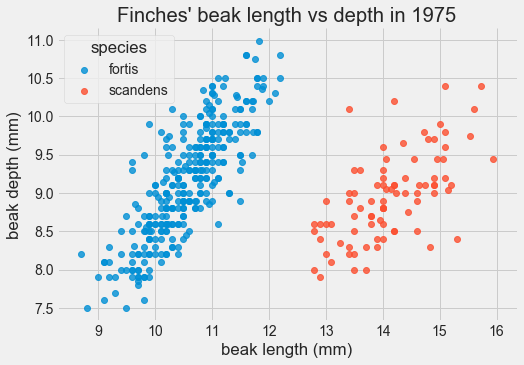

In [110]:
# scatter plot of beak length and depth for finches in 1975 (all data)
sns.lmplot(x='blength', y='bdepth', data=data_1975, fit_reg=False, hue='species', legend_out=False, aspect=1.5)
plt.title("Finches' beak length vs depth in 1975")
plt.xlabel('beak length (mm)')
plt.ylabel('beak depth (mm)')

Even though the measured beak depths are similar between the two species, the data relative to the beak length is quite separated, being visibly smaller for the *Geospiza fortis*. It should be no surprise that if we apply a **$k$-nearest neighbor classification algorithm** we can easily predict the species for new data.

Just to test it, we are going to apply this algorithm using the `KNeighborClassifier` class in the `neighbors` module of `scikit-learn`.

In [111]:
# import relevant packages
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

First, let's split the data into **training data** and **test data**, using the `train_test_split` function.

In [112]:
# split training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_1975[['blength', 'bdepth']], data_1975['species'], random_state=0)

# print shapes
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (302, 2)
y_train shape: (302,)
X_test shape: (101, 2)
y_test shape: (101,)


We have 75% of the original data in the training data and the remaining 25% in the test data. We can have a visual idea of the split through the following plot.

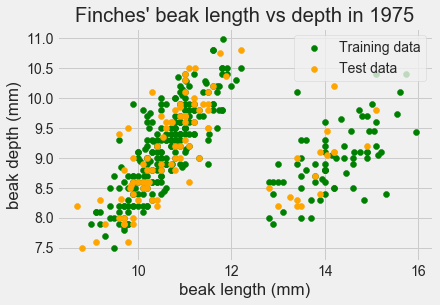

In [113]:
# plot of training and test data
plt.scatter(X_train['blength'], X_train['bdepth'], c='green')
plt.scatter(X_test['blength'], X_test['bdepth'], c='orange')
plt.title("Finches' beak length vs depth in 1975")
plt.xlabel('beak length (mm)')
plt.ylabel('beak depth (mm)')
plt.legend(('Training data', 'Test data'))

We are going to fit the training data (in green in the above plot) using a $k$-nearest neighbor classification algorithm, with $k \in \{1, 2, \ldots, 10\}$. This is one of the simplest machine learning models, as it only stores the training data and, to make a prediction for a new data point, the algorithm finds the $k$ nearest points in the training data and then uses the majority class among the neighbors.

As an example, imagine we apply the algorithm with $k=3$ and want to predict the species for the test point with coordinates $(14.05, 9.45)$. The algorithm finds the $3$ nearest neighbors in the training data (as in the plot below) and the prediction corresponds to the majority species of those $3$ points.

[13, 15, 8.75, 10.25]

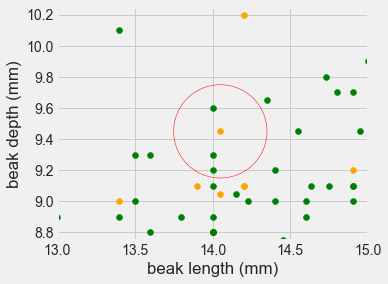

In [114]:
# zoom of previous plot
fig, ax = plt.subplots(1)
ax.set_aspect('equal')

plt.scatter(X_train['blength'], X_train['bdepth'], c='green')
plt.scatter(X_test['blength'], X_test['bdepth'], c='orange')
plt.xlabel('beak length (mm)')
plt.ylabel('beak depth (mm)')
#plt.legend(('Training data', 'Test data'))

# circle around a test point (14.05, 9.45)
ax.add_patch(plt.Circle((14.05, 9.45), 0.3, color='red', fill=False))

# plot range
plt.axis([13,15,8.75,10.25])

We instantiate the class `KNeighborClassifier` in `scikit-learn` into an object, with $k \in \{1, 2, \ldots, 10\}$, and fit the training data.

In [115]:
# fit k-nearest neighbors classification algorithm
knn = [KNeighborsClassifier(n_neighbors=n+1) for n in range(10)]
for n in range(10) :
    knn[n].fit(X_train, y_train)

We can now make predictions using this model. For example, for the first test point:

In [116]:
print("Test point: ({}, {})".format(X_test.iloc[0,0], X_test.iloc[0,1]))
print("Predicted species:", knn[0].predict(X_test)[0])
print("Actual species:", y_test.iloc[0])

Test point: (9.6, 9.4)
Predicted species: fortis
Actual species: fortis


We see that, for the first test point, the prediction is in agreement with the real species. Below, we plot the test data **accuracy** of the model for each $k$, that is, the fraction of test points for which the right species was predicted.

Text(0.5, 1.0, 'Accuracy for $k$-nearest neighboor algorithm')

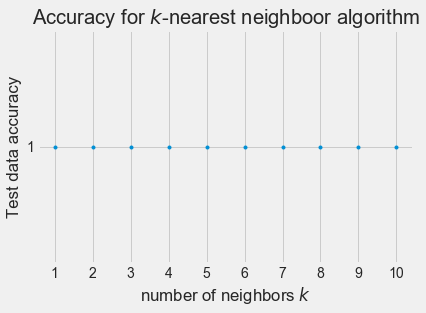

In [117]:
# construct x and y
x_score = np.arange(1, 11)
y_score = np.array([knn[n].score(X_test, y_test) for n in range(10)])

# plot test set score as a function of the number of neighbors
plt.plot(x_score, y_score, '.')
plt.xlabel("number of neighbors $k$")
plt.xticks(range(1,11))
plt.ylabel("Test data accuracy")
plt.yticks([1])
plt.title("Accuracy for $k$-nearest neighboor algorithm")

The test set accuracy is 100% for all number of neighbors $k \in \{1, 2, \ldots, 10\}$. This is because the data is very well separated between the two species, and therefore applying a machine learning model for this dataset is overkill!

**Note also** that the `$k$` in the plt.title shows that inline $\LaTeX$ math expressions are allowed in matplotlib figures.

### End of notebook.